# Convergence

Description of the UCI protocol: https://ucichessengine.wordpress.com/2011/03/16/description-of-uci-protocol/

Let us parse the logs first:

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
! grep "multipv 1" log3.txt  | grep -v lowerbound | grep -v upperbound > log3_g.txt

In [3]:
def parse_info(l):
    D = {}
    k = l.split()
    i = 0
    assert k[i] == "info"
    i += 1
    while i < len(k):
        if k[i] == "depth":
            D[k[i]] = int(k[i+1])
            i += 2
        elif k[i] == "seldepth":
            D[k[i]] = int(k[i+1])
            i += 2
        elif k[i] == "multipv":
            D[k[i]] = int(k[i+1])
            i += 2
        elif k[i] == "score":
            if k[i+1] == "cp":
                D["score_p"] = int(k[i+2]) / 100. # score in pawns
            i += 3
        elif k[i] == "nodes":
            D[k[i]] = int(k[i+1])
            i += 2
        elif k[i] == "nps":
            D[k[i]] = int(k[i+1])
            i += 2
        elif k[i] == "hashfull":
            D[k[i]] = int(k[i+1]) / 1000. # between 0 and 1
            i += 2
        elif k[i] == "tbhits":
            D[k[i]] = int(k[i+1])
            i += 2
        elif k[i] == "time":
            D[k[i]] = int(k[i+1]) / 1000. # elapsed time in [s]
            i += 2
        elif k[i] == "pv":
            D[k[i]] = k[i+1:]
            return D
        else:
            raise Exception("Unknown kw")

In [4]:
# Convert to an array of lists
D = []
for l in open("log3_g.txt").readlines():
    D.append(parse_info(l))

# Convert to a list of arrays
data = {}
for key in D[-1].keys():
    d = []
    for x in D:
        if key in x:
            d.append(x[key])
        else:
            d.append(-1)
    if key != "pv":
        d = array(d)
    data[key] = d

## The Speed of Search

The number of nodes searched depend linearly on time:

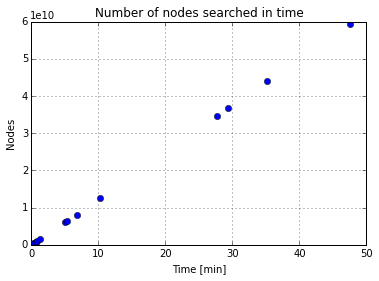

In [5]:
title("Number of nodes searched in time")
plot(data["time"] / 60., data["nodes"], "o")
xlabel("Time [min]")
ylabel("Nodes")
grid()
show()

So nodes per second is roughly constant:

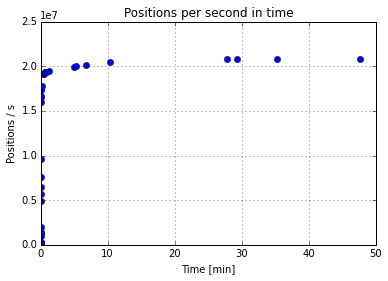

In [6]:
title("Positions per second in time")
plot(data["time"] / 60., data["nps"], "o")
xlabel("Time [min]")
ylabel("Positions / s")
grid()
show()

The hashtable usage is at full capacity:

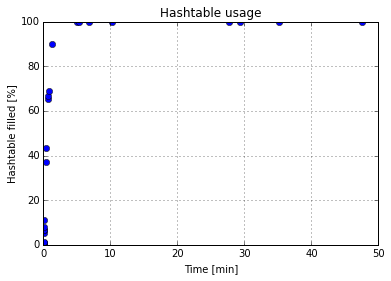

In [7]:
title("Hashtable usage")
hashfull = data["hashfull"]
hashfull[hashfull == -1] = 0
plot(data["time"] / 60., hashfull * 100, "o")
xlabel("Time [min]")
ylabel("Hashtable filled [%]")
grid()
show()

Number of nodes needed for the given depth grows exponentially, except for moves that are forced, which require very little nodes to search (those show as a horizontal plateau):

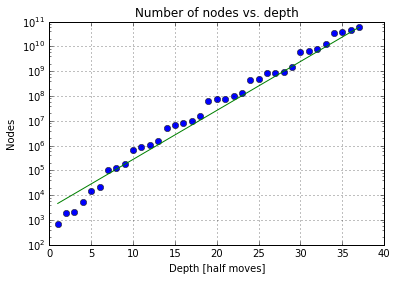

In [8]:
title("Number of nodes vs. depth")
semilogy(data["depth"], data["nodes"], "o")
x = data["depth"]
y = exp(x/2.2)
y = y / y[-1] * data["nodes"][-1]
semilogy(x, y, "-")
xlabel("Depth [half moves]")
ylabel("Nodes")
grid()
show()

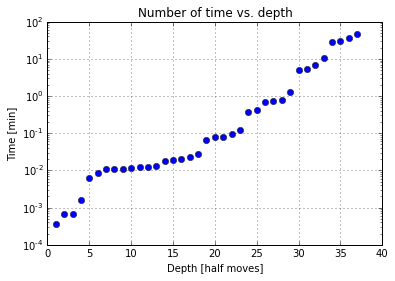

In [9]:
title("Number of time vs. depth")
semilogy(data["depth"], data["time"]/60., "o")
xlabel("Depth [half moves]")
ylabel("Time [min]")
grid()
show()

## Convergence wrt. Depth

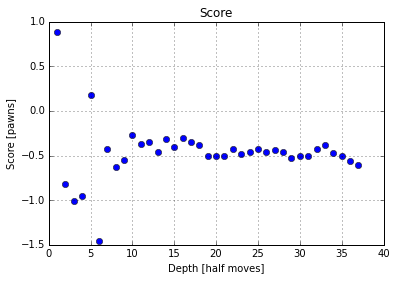

In [10]:
title("Score")
plot(data["depth"], data["score_p"], "o")
xlabel("Depth [half moves]")
ylabel("Score [pawns]")
grid()
show()

Convergence of the variations:

In [11]:
for i in range(len(data["depth"])):
    print "%2i %s" % (data["depth"][i], " ".join(data["pv"][i])[:100])

 1 d1f3
 2 d1f3 d6d5
 3 d1f3 d6d5 a2a3
 4 d1f3 f7e8 d2d3 c7c6
 5 d1f3 h7h5 f1c4 f7e7 d2d4 b8c6
 6 d1f3 c8g4 f3f4 b8c6 b1c3 f7e8
 7 d2d4 c7c6 e4e5 c8g4 d1d2 d8e7 f2f3
 8 d2d4 c7c6 d1d3 d8e8 f2f3 c8e6 b1c3 b8a6
 9 b1c3 c7c6 d2d4 b7b5 d1d3 b8a6 e4e5 d6e5 d4e5
10 d2d4 c7c5 b1c3 b8c6 f1c4 d6d5 c3d5 c6a5 c4b5 f6d5 d4c5
11 d2d4 c8e6 f1d3 f7g8 e1g1 b8d7 b1c3 c7c6 f1e1 d7b6 c1e3
12 d2d4 c8e6 f1d3 f7g8 e1g1 b8d7 b1c3 c7c6 f1e1 d8b6 e4e5 d6e5 d4e5 f6d5 d3c4
13 d2d4 c7c6 f1d3 c8g4 d1d2 b8d7 e1g1 f7g8 b1c3 g4e6 f1e1 h7h5 d2e2 f8e7 e4e5
14 d2d4 c8e6 f1d3 c7c5 d4d5 e6d7 b1c3 f8e7 d1f3 h7h5 a2a3 f7g8 e1g1 d8b6
15 d2d4 c8g4 f2f3 g4e6 b1c3 f7g8 f1e2 h7h5 e1g1 b8d7 c1g5 f8e7 d1d2 c7c5 a1d1 c5d4
16 d2d4 c8g4 f2f3 g4e6 b1c3 f7g8 f1e2 h7h5 c1g5 f8e7 h2h4 d6d5 e4e5 f6d7 f3f4 b8c6 e1g1 e6f7 g1h1
17 d2d4 c8g4 f2f3 g4e6 b1c3 f7g8 f1e2 b8d7 d1d3 c7c6 c1g5 h7h6 g5e3 a7a6 e1c1 h6h5 e3g5
18 d2d4 c8g4 f2f3 g4e6 b1c3 d6d5 e4e5 f6h5 c1e3 c7c5 d4c5 b8c6 f3f4 g7g6 g2g4 d8h4 e3f2 h4g4 d1g4 e6g4 
19 b1c3 c8e6 d2d4 f7g8 f1